## Adversarial Attack

In [1]:
# %pip install -q pillow
# %pip install -q numpy
# %pip install -q scipy
# %pip install -q matplotlib
# %pip install -q torchinfo
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights

from tqdm import trange
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cuda':
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # torch.set_float32_matmul_precision("medium")

print(f"Available device: {device.type}")

Available device: cuda


### Dataset Download

In [4]:
normalize_fn = v2.Compose(
    [
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

denormalize_fn = v2.Compose(
    [
        v2.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        ),
    ]
)

def image2tensor(image):
    return normalize_fn(image.clone().permute(2,0,1)/255.)[None]

def tensor2image(tensor):
    return (denormalize_fn(tensor[0].clone()).permute(1, 2, 0) * 255.0).type(torch.uint8)

In [5]:
DATA_PATH = "../datasets"
MINIBATCH_SIZE = 64
EPOCHS = 10

original_image = Image.open(
    os.path.join(DATA_PATH, "african-elephant-square.jpg")
).convert("RGB")
original_image = np.array(original_image)
original_image = torch.tensor(original_image)

In [6]:
image_net_classes = os.path.join(DATA_PATH, "imagenet1000_clsidx_to_labels.txt")
image_net_ids = eval(open(image_net_classes).read())
image_net_classes = {i: j for j, i in image_net_ids.items()}

In [7]:
resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2, progress=False)

In [8]:
def predict_on_image(input, model):
    model.eval()
    plt.imshow(input)
    plt.show()
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clazz = torch.max(pred, 0)
    clazz = image_net_ids[clazz.item()]
    print(f'PREDICTION: `{clazz}` @ {prob.item():.4f}')
    return prob, clazz

In [9]:
def attack(
    image: torch.Tensor,
    model: nn.Module,
    target: torch.Tensor,
    epsilon=1e-6,
):
    image = image2tensor(image)
    image.requires_grad = True
    pred = model(image)
    loss = F.cross_entropy(pred, target)
    loss.backward()
    output = image - epsilon * image.grad.sign()
    output = tensor2image(output)
    return output.detach()

In [10]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [11]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for i in trange(EPOCHS):
        image_to_attack = attack(image_to_attack, resnet_model, target)
    modified_images.append(image_to_attack)

100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


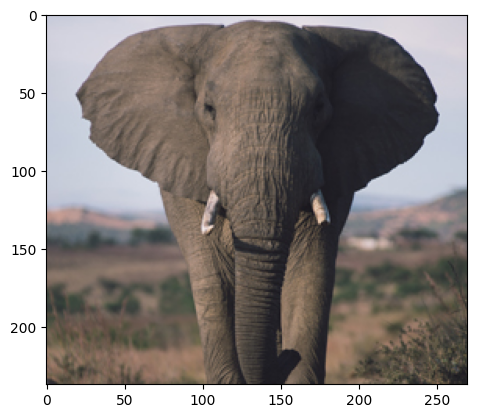

PREDICTION: `African elephant, Loxodonta africana` @ 0.0040


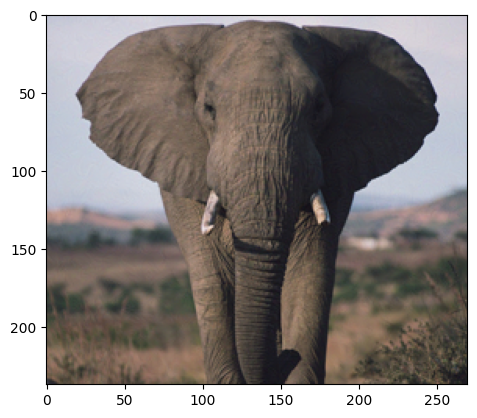

PREDICTION: `lemon` @ 0.0219


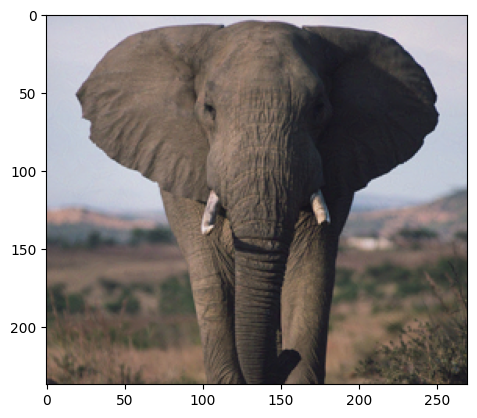

PREDICTION: `comic book` @ 0.0225


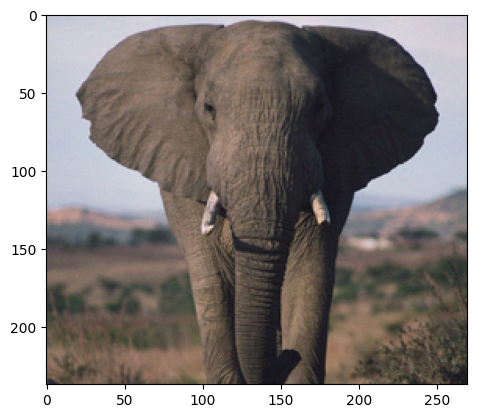

PREDICTION: `sax, saxophone` @ 0.0318


In [12]:
for image in [original_image, *modified_images]:
    predict_on_image(image, resnet_model)